<a href="https://colab.research.google.com/github/rjin1/NICE_Experiments_Notebook/blob/main/NICE_SynGumbelSourceExperiment_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch.optim as optim
import torch
import torch.utils.data as data
import torch.autograd as autograd
from torch.utils.data import Dataset
import torch.nn.init as init
import torch.nn as nn

from scipy.io import loadmat
from scipy.io import savemat
import scipy.stats as scistats

import matplotlib.pyplot as plt

import sys
import os

import argparse

# np.set_printoptions(threshold=sys.maxsize)


In [ ]:
def Gen_Source(loc_filename = './drive/MyDrive/NICE_JupyterNotebook/DistributionParams/SM_params_locat.mat', loc_varname = 'locat_param', 
               scale_filename = './drive/MyDrive/NICE_JupyterNotebook/DistributionParams/SM_params_scale.mat', sacle_varname = 'scale_param', N_sample = 7668, seed_gs = 1):
  
  loc = loadmat(loc_filename)[loc_varname].astype(np.float64)
  scale = loadmat(scale_filename)[sacle_varname].astype(np.float64)

  # Assume the loc and scale are in same format np.array in (N_source x 1)
  N_source = loc.shape[0]
  S = np.zeros((N_source, N_sample), np.float64)

  # Control the RNG for repro
  np.random.seed(seed_gs)
  for i in range(N_source):
    S[i,:] = np.random.gumbel(loc[i,0], scale[i,0], (1, N_sample))

  return S

In [ ]:
def Gen_Mixture(S, ratio=1):
  # Assume S is in np.array format in (N_souece x N_sample)
  N_source_sample = S.shape
  X = np.zeros((N_source_sample[0], N_source_sample[1]), np.float64)

  for i in range(N_source_sample[1]):
    for j in range(N_source_sample[0]):
      X[j,i] = S[j,i] + ratio * (S[j,i] * (np.sum(S[:,i]) - S[j,i]) + np.sum(S[:,i] ** 2) - S[j,i] ** 2)

  return X 

In [ ]:
def Train_Valid_Split(Data, N_train, N_valid, seed_tvs):
  # Assume data in format np.array with (N_source x N_sample)
  N_sample = Data.shape[1]
  
  np.random.seed(seed_tvs)
  ind_all = np.random.permutation(N_sample)
  ind_train = ind_all[:N_train]
  ind_valid = ind_all[N_train:N_train+N_valid]

  Data_train = Data[:,ind_train]
  Data_valid = Data[:,ind_valid]

  return Data_train, Data_valid
  

In [ ]:
def Add_Noise(Data, SNR, seed):
  # Add Gaussian noise per mixture with SNR
  np.random.seed(seed)
  N_source_sample = Data.shape
  Noisy_Data = np.zeros(N_source_sample, np.float64)
  
  for i in range(N_source_sample[0]):
    Noisy_Data[i,:] = Data[i,:] + (np.std(Data[i,:]) / np.sqrt(SNR)) * np.random.randn(N_source_sample[1])

  return Noisy_Data

In [ ]:
def load_fMRI_regression(Data_in, batch_size=10, if_CUDA=True, if_shuffle=False):
    return data.DataLoader(
        LOAD_FMRI_regression(Data_in),
        batch_size=batch_size,
        pin_memory=if_CUDA,
        shuffle=if_shuffle
    )

In [ ]:
class LOAD_FMRI_regression(Dataset):
    def __init__(self, Data_in):
        # Input training, validation or test data sets as Data_in below to make this class a corresponding loader.
        self.Data_in = Data_in

    def __len__(self):
        return len(self.Data_in)

    def __getitem__(self, idx):
        sample = self.Data_in[idx]
        return sample


In [ ]:
# Implementation of models from paper.
def _build_relu_network1(hidden_dim, dropout_p):
    """Helper function to construct a ReLU network of varying number of layers."""
    _modules = [nn.Dropout(p=dropout_p)]
    _modules.append(nn.Linear(8, hidden_dim, bias=True))
    _modules.append(nn.ReLU())
    _modules.append(nn.Dropout(p=dropout_p))
    _modules.append(nn.Linear(hidden_dim, 8, bias=True))
    return nn.Sequential(*_modules)


def _build_relu_network2(hidden_dim, dropout_p):
    """Helper function to construct a ReLU network of varying number of layers."""
    _modules = [nn.Dropout(p=dropout_p)]
    _modules.append(nn.Linear(8, hidden_dim, bias=True))
    _modules.append(nn.ReLU())
    _modules.append(nn.Dropout(p=dropout_p))
    _modules.append(nn.Linear(hidden_dim, 8, bias=True))
    return nn.Sequential(*_modules)


def _build_relu_network3(hidden_dim, dropout_p):
    _modules = [nn.Dropout(p=dropout_p)]
    _modules.append(nn.Linear(8, hidden_dim, bias=True))
    _modules.append(nn.ReLU())
    _modules.append(nn.Dropout(p=dropout_p))
    _modules.append(nn.Linear(hidden_dim, 8, bias=True))
    return nn.Sequential(*_modules)


# def _build_relu_network4(hidden_dim, dropout_p):
    # """Helper function to construct a ReLU network of varying number of layers."""
    # _modules = [nn.Dropout(p=dropout_p)]
    # _modules.append(nn.Linear(8, hidden_dim, bias=True))
    # _modules.append(nn.ReLU())
    # _modules.append(nn.Dropout(p=dropout_p))
    # _modules.append(nn.Linear(hidden_dim, 8, bias=True))
    # return nn.Sequential(*_modules)


#
# def _build_relu_network5(hidden_dim, dropout_p):
#     """Helper function to construct a ReLU network of varying number of layers."""
#     _modules = [nn.Dropout(p=dropout_p)]
#     _modules.append(nn.Linear(8, hidden_dim, bias=True))
#     _modules.append(nn.ReLU())
#     _modules.append(nn.Dropout(p=dropout_p))
#     _modules.append(nn.Linear(hidden_dim, 8, bias=True))
#     return nn.Sequential(*_modules)


# def _build_relu_network6(hidden_dim, dropout_p):
#     """Helper function to construct a ReLU network of varying number of layers."""
#     _modules = [nn.Dropout(p=dropout_p)]
#     _modules.append(nn.Linear(8, hidden_dim, bias=True))
#     _modules.append(nn.ReLU())
#     _modules.append(nn.Dropout(p=dropout_p))
#     _modules.append(nn.Linear(hidden_dim, 8, bias=True))
#     return nn.Sequential(*_modules)


class NICEModel(nn.Module):
    """
    Replication of model from the paper:
      "Nonlinear Independent Components Estimation",
      Laurent Dinh, David Krueger, Yoshua Bengio (2014)
      https://arxiv.org/abs/1410.8516

    Contains the following components:
    * four additive coupling layers with nonlinearity functions consisting of
      five-layer RELUs
    * a diagonal scaling matrix output layer
    """

    def __init__(self, input_dim, hidden_dim, init_interval, dropout_p, init_filepath, seed):
        # def __init__(self, input_dim, hidden_dim, init_interval, dropout_p, init_filepath, param1, param2):
        super(NICEModel, self).__init__()
        assert (input_dim % 2 == 0), "[NICEModel] only even input dimensions supported for now"
        self.input_dim = input_dim
        half_dim = int(input_dim / 2)
        self.layer1 = AdditiveCouplingLayer(input_dim, 'odd', _build_relu_network1(hidden_dim, dropout_p))
        self.layer2 = AdditiveCouplingLayer(input_dim, 'even', _build_relu_network2(hidden_dim, dropout_p))
        self.layer3 = AdditiveCouplingLayer(input_dim, 'odd', _build_relu_network3(hidden_dim, dropout_p))
        # self.layer4 = AdditiveCouplingLayer(input_dim, 'even', _build_relu_network4(hidden_dim, dropout_p))
        # self.layer5 = AdditiveCouplingLayer(input_dim, 'odd', _build_relu_network5(hidden_dim, dropout_p))
        # self.layer6 = AdditiveCouplingLayer(input_dim, 'even', _build_relu_network6(hidden_dim, dropout_p))
        # Rui: Initialize scaling layer parameters.
        self.scaling_diag = nn.Parameter(torch.zeros(input_dim), requires_grad=True)
        # self.param1 = nn.Parameter(torch.tensor(param1), requires_grad=True)
        # self.param2 = nn.Parameter(torch.tensor(param2), requires_grad=True)
        # self.scaling_diag = nn.Parameter(torch.tensor(loadmat(init_filepath)['scaling_diag'].astype(np.float64)[0][:])
        #                                  , requires_grad=True)
        # randomly initialize weights:
        # RNG control   
        torch.manual_seed(seed)
        # ind = 1
        for p in self.layer1.parameters():
            if len(p.shape) > 1:
                # init.kaiming_uniform_(p, nonlinearity='relu')
                # init.normal_(p, mean=0., std=0.1)
                # with torch.no_grad():
                #     p.copy_(torch.from_numpy(
                #         loadmat(init_filepath)['layer1nonlinearityweight_'+str(ind)].astype(np.float64)))
                # ind = ind + 1
                init.uniform_(p, a=-init_interval, b=init_interval)
            else:
                # init.normal_(p)
                # with torch.no_grad():
                #     p.copy_(torch.squeeze(torch.from_numpy(
                #         loadmat(init_filepath)['layer1nonlinearitybias_'+str(ind)].astype(np.float64))))
                # ind = ind + 1
                init.zeros_(p)
        # ind = 1
        for p in self.layer2.parameters():
            if len(p.shape) > 1:
                # init.kaiming_uniform_(p, nonlinearity='relu')
                # init.normal_(p, mean=0., std=0.1)
                init.uniform_(p, a=-init_interval, b=init_interval)
                # with torch.no_grad():
                #     p.copy_(torch.from_numpy(
                #         loadmat(init_filepath)['layer2nonlinearityweight_'+str(ind)].astype(np.float64)))
                # ind = ind + 1
            else:
                # init.normal_(p)
                init.zeros_(p)
                # with torch.no_grad():
                #     p.copy_(torch.squeeze(torch.from_numpy(
                #         loadmat(init_filepath)['layer2nonlinearitybias_'+str(ind)].astype(np.float64))))
                # ind = ind + 1
        # ind = 1
        for p in self.layer3.parameters():
            if len(p.shape) > 1:
                # init.kaiming_uniform_(p, nonlinearity='relu')
                # init.normal_(p, mean=0., std=0.1)
                init.uniform_(p, a=-init_interval, b=init_interval)
                # with torch.no_grad():
                #     p.copy_(torch.from_numpy(
                #         loadmat(init_filepath)['layer3nonlinearityweight_'+str(ind)].astype(np.float64)))
                # ind = ind + 1
            else:
                # init.normal_(p)
                # with torch.no_grad():
                #     p.copy_(torch.squeeze(torch.from_numpy(
                #         loadmat(init_filepath)['layer3nonlinearitybias_'+str(ind)].astype(np.float64))))
                # ind = ind + 1
                init.zeros_(p)
        # ind = 1
        # for p in self.layer4.parameters():
        #     if len(p.shape) > 1:
                # init.kaiming_uniform_(p, nonlinearity='relu')
        #         init.uniform_(p, a=-init_interval, b=init_interval)
        #         # init.normal_(p, mean=0., std=0.1)
        #         # with torch.no_grad():
        #         #     p.copy_(torch.from_numpy(
        #         #         loadmat(init_filepath)['layer4nonlinearityweight_'+str(ind)].astype(np.float64)))
        #         # ind = ind + 1
        #     else:
        #         # with torch.no_grad():
        #         #     p.copy_(torch.squeeze(torch.from_numpy(
        #         #         loadmat(init_filepath)['layer4nonlinearitybias_'+str(ind)].astype(np.float64))))
        #         # ind = ind + 1
        #         init.zeros_(p)
        # ind = 1
        # for p in self.layer5.parameters():
        #     if len(p.shape) > 1:
        #         # init.kaiming_uniform_(p, nonlinearity='relu')
        #         init.uniform_(p, a=-init_interval, b=init_interval)
        #         # init.normal_(p, mean=0., std=0.1)
        #         # with torch.no_grad():
        #         #     p.copy_(torch.from_numpy(
        #         #         loadmat(init_filepath)['layer5nonlinearityweight_'+str(ind)].astype(np.float64)))
        #         # ind = ind + 1
        #     else:
        #         # with torch.no_grad():
        #         #     p.copy_(torch.squeeze(torch.from_numpy(
        #         #         loadmat(init_filepath)['layer5nonlinearitybias_'+str(ind)].astype(np.float64))))
        #         # ind = ind + 1
        #         init.zeros_(p)
        # ind = 1
        # for p in self.layer6.parameters():
        #     if len(p.shape) > 1:
        #         # init.kaiming_uniform_(p, nonlinearity='relu')
        #         init.uniform_(p, a=-init_interval, b=init_interval)
        #         # init.normal_(p, mean=0., std=0.1)
        #         # with torch.no_grad():
        #         #     p.copy_(torch.from_numpy(
        #         #         loadmat(init_filepath)['layer6nonlinearityweight_'+str(ind)].astype(np.float64)))
        #         # ind = ind + 1
        #     else:
        #         # with torch.no_grad():
        #         #     p.copy_(torch.squeeze(torch.from_numpy(
        #         #         loadmat(init_filepath)['layer6nonlinearitybias_'+str(ind)].astype(np.float64))))
        #         # ind = ind + 1
        #         init.zeros_(p)
        

    def forward(self, xs):
        """
        Forward pass through all invertible coupling layers.

        Args:
        * xs: float tensor of shape (B,dim).

        Returns:
        * ys: float tensor of shape (B,dim).
        """
        ys = self.layer1(xs)
        ys = self.layer2(ys)
        ys = self.layer3(ys)
        # ys = self.layer4(ys)
        # ys = self.layer5(ys)
        # ys = self.layer6(ys)
        # ys = self.layer7(ys)
        ys_scale = torch.matmul(ys, torch.diag(torch.exp(self.scaling_diag)))
        return ys_scale, ys
        
    def inverse(self, ys):
        """Invert a set of draws from gaussians"""
        with torch.no_grad():
            xs = torch.matmul(ys, torch.diag(torch.reciprocal(torch.exp(self.scaling_diag))))
            xs = self.layer4.inverse(xs)
            xs = self.layer3.inverse(xs)
            xs = self.layer2.inverse(xs)
            xs = self.layer1.inverse(xs)
        return xs

# Implementation of NICE bijective triangular-jacobian layers.
# ===== ===== Coupling Layer Implementations ===== =====
#
# _get_even = lambda xs: xs[:,::2]
# _get_odd = lambda xs: xs[:,1::2]
_get_even = lambda xs: xs[:, 8:]
_get_odd = lambda xs: xs[:, :8]
# _get_even = lambda xs: xs[:, 1:]
# _get_odd = lambda xs: xs[:, :1]


def _interleave(first, second, order):
    """
    Given 2 rank-2 tensors with same batch dimension, interleave their columns.
    
    The tensors "first" and "second" are assumed to be of shape (B,M) and (B,N)
    where M = N or N+1, repsectively.
    """
    cols = []
    # if order == 'even':
    #     for k in range(second.shape[1]):
    #         cols.append(first[:,k])
    #         cols.append(second[:,k])
    #     if first.shape[1] > second.shape[1]:
    #         cols.append(first[:,-1])
    # else:
    #     for k in range(first.shape[1]):
    #         cols.append(second[:,k])
    #         cols.append(first[:,k])
    #     if second.shape[1] > first.shape[1]:
    #         cols.append(second[:,-1])
    if order == 'even':
         cols.append(second)
         cols.append(first)
    else:
         cols.append(first)
         cols.append(second)
    # return torch.stack(cols, dim=1)
    return torch.cat(cols, dim=1)


class _BaseCouplingLayer(nn.Module):
    def __init__(self, dim, partition, nonlinearity):
        """
        Base coupling layer that handles the permutation of the inputs and wraps
        an instance of torch.nn.Module.

        Usage:
        >> layer = AdditiveCouplingLayer(1000, 'even', nn.Sequential(...))
        
        Args:
        * dim: dimension of the inputs.
        * partition: str, 'even' or 'odd'. If 'even', the even-valued columns are sent to
        pass through the activation module.
        * nonlinearity: an instance of torch.nn.Module.
        """
        super(_BaseCouplingLayer, self).__init__()
        # store input dimension of incoming values:
        self.dim = dim
        # store partition choice and make shorthands for 1st and second partitions:
        assert (partition in ['even', 'odd']), "[_BaseCouplingLayer] Partition type must be `even` or `odd`!"
        self.partition = partition
        if (partition == 'even'):
            self._first = _get_even
            self._second = _get_odd
        else:
            self._first = _get_odd
            self._second = _get_even
        # store nonlinear function module:
        # (n.b. this can be a complex instance of torch.nn.Module, for ex. a deep ReLU network)
        self.add_module('nonlinearity', nonlinearity)

    def forward(self, x):
        """Map an input through the partition and nonlinearity."""
        return _interleave(
            self._first(x),
            self.coupling_law(self._second(x), self.nonlinearity(self._first(x))),
            self.partition
        )

    def inverse(self, y):
        """Inverse mapping through the layer. Gradients should be turned off for this pass."""
        return _interleave(
            self._first(y),
            self.anticoupling_law(self._second(y), self.nonlinearity(self._first(y))),
            self.partition
        )

    def coupling_law(self, a, b):
        # (a,b) --> g(a,b)
        raise NotImplementedError("[_BaseCouplingLayer] Don't call abstract base layer!")

    def anticoupling_law(self, a, b):
        # (a,b) --> g^{-1}(a,b)
        raise NotImplementedError("[_BaseCouplingLayer] Don't call abstract base layer!")


class AdditiveCouplingLayer(_BaseCouplingLayer):
    """Layer with coupling law g(a;b) := a + b."""
    def coupling_law(self, a, b):
        return (a + b)
    def anticoupling_law(self, a, b):
        return (a - b)


In [ ]:
# Implementation of NICE log-likelihood loss.

# ===== ===== Loss Function Implementations ===== =====
"""
We assume that we final output of the network are components of a multivariate distribution that
factorizes, i.e. the output is (y1,y2,...,yK) ~ p(Y) s.t. p(Y) = p_1(Y1) * p_2(Y2) * ... * p_K(YK),
with each individual component's prior distribution coming from a standardized family of
distributions, i.e. p_i == Gaussian(mu,sigma) for all i in 1..K, or p_i == Logistic(mu,scale).
"""


def gaussian_nice_loglkhd(h, diag):
    """
    Definition of log-likelihood function with a Gaussian prior, as in the paper.
    
    Args:
    * h: float tensor of shape (N,D). First dimension is batch dim, second dim consists of components
      of a factorized probability distribution.
    * diag: scaling diagonal of shape (D,).

    Returns:
    * loss: torch float tensor of shape (N,).
    """
    # \sum^D_i s_{ii} - { (1/2) * \sum^D_i  h_i**2) + (D/2) * log(2\pi) }
    return torch.sum(diag) - (
            0.5 * torch.sum(torch.pow(h, 2), dim=1) + h.size(1) * 0.5 * torch.log(torch.tensor(2 * np.pi)))


def logistic_nice_loglkhd(h, diag):
    """
    Definition of log-likelihood function with a Logistic prior.
    
    Same arguments/returns as gaussian_nice_loglkhd.
    """
    # \sum^D_i s_{ii} - { \sum^D_i log(exp(h)+1) + torch.log(exp(-h)+1) }
    return (torch.sum(diag) - (torch.sum(torch.log1p(torch.exp(h)) + torch.log1p(torch.exp(-h)), dim=1)))


# def gumbel_nice_loglkhd(DEVICE, h, diag):
def gumbel_nice_loglkhd(DEVICE, h, diag, loc, scale):
    """
    Definition of log-likelihood function with a Gumbel prior.

    Args:
        h: float tensor of shape (N,D). First dimension is batch dim, second dim consists of components
      of a factorized probability distribution.
        diag: scaling diagonal of shape (D,).

    PDF:exp(-(x - mu) / sigma - exp(-(x - mu) / sigma)) / sigma
    It is the formula in both tfp.distributions.Gumbel and torch.distributions
    Returns:
    * loss: torch float tensor of shape (N,).
    """
    # The location is determined so that mean is 0. When scale = 1, loc = -scale*euler_constant
    # loc = torch.ones(h.size()).to(DEVICE) * (-euler_constant)
    # loc = torch.zeros(h.size()).to(DEVICE)
    # scale = torch.ones(h.size()).to(DEVICE)
    loc = torch.tensor(loc, requires_grad=False).to(DEVICE)
    # loc = torch.transpose(loc, 0, 1)
    loc = loc.repeat(h.size(0), 1)
    scale = torch.tensor(scale, requires_grad=False).to(DEVICE)
    # scale = torch.transpose(scale, 0, 1)
    scale = scale.repeat(h.size(0), 1)
    Gumbelloglikelihood = torch.distributions.gumbel.Gumbel(loc, scale).log_prob(h)
    return torch.sum(diag) + (torch.sum(Gumbelloglikelihood) / h.size(0))


# wrap above loss functions in Modules:
class GaussianPriorNICELoss(nn.Module):
    def __init__(self, size_average=True):
        super(GaussianPriorNICELoss, self).__init__()
        self.size_average = size_average

    def forward(self, fx, diag):
        if self.size_average:
            return torch.mean(-gaussian_nice_loglkhd(fx, diag))
        else:
            return torch.sum(-gaussian_nice_loglkhd(fx, diag))


class LogisticPriorNICELoss(nn.Module):
    def __init__(self, size_average=True):
        super(LogisticPriorNICELoss, self).__init__()
        self.size_average = size_average

    def forward(self, fx, diag):
        if self.size_average:
            return torch.mean(-logistic_nice_loglkhd(fx, diag))
        else:
            return torch.sum(-logistic_nice_loglkhd(fx, diag))


class GumbelPriorNICELoss(nn.Module):
    def __init__(self, DEVICE, size_average=True):
        super(GumbelPriorNICELoss, self).__init__()
        self.size_average = size_average
        self.DEVICE = DEVICE

    # def forward(self, fx, diag, diag1):
    # def forward(self, fx, diag):
    def forward(self, fx, diag, loc, scale):
        if self.size_average:
            return torch.mean(-gumbel_nice_loglkhd(self.DEVICE, fx, diag))
            # return torch.mean(-gumbel_nice_loglkhd(self.DEVICE, fx, diag, loc, scale))
            # return torch.mean(-gumbel_nice_loglkhd(self.DEVICE, fx, diag, diag1))
        else:
            # return -gumbel_nice_loglkhd(self.DEVICE, fx, diag)
            return -gumbel_nice_loglkhd(self.DEVICE, fx, diag, loc, scale)
            # return torch.sum(-gumbel_nice_loglkhd(self.DEVICE, fx, diag, diag1))


class regression(nn.Module):
    def __init__(self, DEVICE):
        super(regression, self).__init__()
        self.DEVICE = DEVICE
        self.lrloss = nn.MSELoss(reduction='sum')

    def forward(self, fx, y):
        return 0.5 * self.lrloss(fx, y) / fx.size(0)


In [ ]:
# l1, l2 regularization
def l1_norm(mdl, include_bias=True, device=(torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'))):
    """Compute L1 norm on all the weights of mdl."""
    if include_bias:
        _norm = torch.tensor(0.0, device=device)
        for w in mdl.parameters():
            _norm = _norm + w.norm(p=1)
        return _norm
    else:
        _norm = torch.tensor(0.0)
        for w in mdl.parameters():
            if len(w.shape) > 1:
                _norm = _norm + w.norm(p=1)
        return _norm

def l2_norm(mdl, include_bias=True, device=(torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'))):
    """Compute L1 norm on all the weights of mdl."""
    if include_bias:
        _norm = torch.tensor(0.0, device=device)
        for w in mdl.parameters():
            _norm = _norm + w.norm(p='fro')
        return _norm
    else:
        _norm = torch.tensor(0.0)
        for w in mdl.parameters():
            if len(w.shape) > 1:
                _norm = _norm + w.norm(p='fro')
        return _norm


In [ ]:
def val_fMRI(model, Data_valid, CUDA, dataloader_fn, args, validate):
    """Perform validation on a dataset."""
    # set model to eval mode (turns batch norm training off)
    model.eval()

    # build dataloader in eval mode:
    dataloader_val = dataloader_fn(Data_valid, batch_size=args.batch_size_val, if_CUDA=CUDA, if_shuffle=False)

    # turn gradient-tracking off (for speed) during validation:
    with torch.no_grad():
        for inputs in dataloader_val:
            scaled_output_val, _ = model(inputs.to(DEVICE))
            val_loss = validate(scaled_output_val).item()

    # delete dataloader to save memory:
    del dataloader_val

    # set model back in train mode:
    model.train()

    return val_loss

In [ ]:
def test_fMRI(model, Data_test, CUDA, dataloader_fn, Sources, args, input_dim):
    """Perform validation on a dataset."""
    # set model to eval mode (turns batch norm training off)
    model.eval()

    # build dataloader in eval mode:
    dataloader_test = dataloader_fn(Data_test, batch_size=args.batch_size_test, if_CUDA=CUDA, if_shuffle=False)

    test_z = np.empty((0, input_dim), np.float64)
    test_z_scaled = np.empty((0, input_dim), np.float64)
    with torch.no_grad():
        for inputs in dataloader_test:
            scaled_output_test, output_test = model(inputs.to(DEVICE))
            test_z = np.append(test_z, output_test.detach().cpu().numpy(), axis=0)
            test_z_scaled = np.append(test_z_scaled, scaled_output_test.detach().cpu().numpy(), axis=0)
            # Mean Pearson Correlation
            y_targets = Sources.transpose()
            corr = np.abs(np.corrcoef(test_z.transpose(), y_targets.transpose()))[:input_dim, input_dim:]
            # Permutation correction
            maps_permut_index = np.argmax(corr, axis=0)
            if (np.sort(maps_permut_index) == np.array(range(input_dim), dtype=np.int)).all():
                mpc = np.mean(corr[maps_permut_index, range(input_dim)])
                # Mean square error
                mse = np.mean(np.square(test_z.transpose() - y_targets.transpose()[maps_permut_index, :]))
            else:
                mpc = np.mean(corr.diagonal())
                # Mean square error
                mse = np.mean(np.square(test_z.transpose() - y_targets.transpose()))

            # Mean Pearson Correlation, for scaled z
            corr_scaled = np.abs(np.corrcoef(test_z_scaled.transpose(), y_targets.transpose()))[:input_dim, input_dim:]
            # Permutation correction
            scaled_maps_permut_index = np.argmax(corr_scaled, axis=0)
            if (np.sort(scaled_maps_permut_index) == np.array(range(input_dim), dtype=np.int)).all():
                mpc_scaled = np.mean(corr_scaled[scaled_maps_permut_index, range(input_dim)])
                # Mean square error
                mse_scaled = np.mean(
                    np.square(test_z_scaled.transpose() - y_targets.transpose()[scaled_maps_permut_index, :]))
            else:
                mpc_scaled = np.mean(corr_scaled.diagonal())
                # Mean square error
                mse_scaled = np.mean(np.square(test_z_scaled.transpose() - y_targets.transpose()))

    del dataloader_test

    # set model back in train mode:
    model.train()

    # return test_reg_results
    return corr, maps_permut_index, mpc, mse, mse_scaled, test_z, test_z_scaled


In [ ]:
def train(args, Data_train, Data_valid, Data_test, Sources, DEVICE, CUDA):
  """Construct a NICE model and train over a number of epochs."""
    # === choose which dataset to build:
    # global early_stop_account_start
  if args.dataset == 'fMRI':
    dataloader_fn = load_fMRI_regression
    input_dim = Data_train.shape[0]
    # Loss
    LOSS_train = np.array([], dtype=np.float64)
    LOSS_val = np.array([], dtype=np.float64)
    LOSS_val_epoch = np.array([], dtype=np.float64)
    LR = np.array([], dtype=np.float64)
    # Mean Pearson correlation.-Rui
    MPC = np.array([], dtype=np.float64)
    # Mean square error.-Rui
    MSE = np.array([], dtype=np.float64)
    MSE_scaled = np.array([], dtype=np.float64)
    params_1 = loadmat(args.param1fp)[args.param1vn].transpose().astype(np.float64)
    params_2 = loadmat(args.param2fp)[args.param2vn].transpose().astype(np.float64)

  model = NICEModel(input_dim, args.nhidden, args.init_interval, args.dropout_p, args.init_filepath, args.ModelRNG_seed)
  if (args.model_path is not None):
      assert (os.path.exists(args.model_path)), "[train] model does not exist at specified location"
      model.load_state_dict(torch.load(args.model_path, map_location='cpu'))
  model.to(DEVICE)

  # opt = optim.RMSprop(model.parameters(), lr=args.lr, momentum=0.9)
  opt = optim.Adam(model.parameters(), lr=args.lr, betas=(args.beta1, args.beta2), eps=args.eps)

  # === choose which loss function to build:
  if args.prior == 'logistic':
      nice_loss_fn = LogisticPriorNICELoss(size_average=True)
  if args.prior == 'Gumbel':
      nice_loss_fn = GumbelPriorNICELoss(DEVICE, size_average=False)
  if args.prior == 'prior':
      nice_loss_fn = GaussianPriorNICELoss(size_average=True)
  if args.prior == 'regression':
      nice_loss_fn = regression(DEVICE)
      
  def loss_fn(fx):
      """Compute NICE loss w/r/t a prior and optional L1 or L2 regularization."""
      if args.lmbda == 0.0:
          return nice_loss_fn(fx, model.scaling_diag, params_1, params_2)
          # return nice_loss_fn(fx, model.scaling_diag, model.param1, model.param1)
          # return nice_loss_fn(fx, model.scaling_diag)
          # return nice_loss_fn(fx, model.scaling_diag, model.scaling_diag1)
      else:
          # return nice_loss_fn(fx, model.scaling_diag) + args.lmbda * l1_norm(model, include_bias=True)
          # return nice_loss_fn(fx, model.scaling_diag) + args.lmbda * l2_norm(model, include_bias=True)
          return nice_loss_fn(fx, model.scaling_diag, params_1, params_2) + args.lmbda * l2_norm(model, include_bias=True)
          # return nice_loss_fn(fx, model.scaling_diag, params_1, params_2) + args.lmbda * l1_norm(model, include_bias=True)


  # Validation metric (MLE)
  def validate(fx):
      # return nice_loss_fn(fx, model.scaling_diag)
      return nice_loss_fn(fx, model.scaling_diag, params_1, params_2)
      # return nice_loss_fn(fx, model.scaling_diag, model.param1, model.param1)

  # === train over a number of epochs; perform validation after each iteration:
  # For convergence check
  iter_ind = 0
  early_stop = False
  # early_stop_account_start = False
  early_stop_account = 0
  mpc = 0
  mse = 0
  for epoch in range(args.num_epochs):
      if early_stop:
          break
      dataloader_train = dataloader_fn(Data_train.transpose(), batch_size=args.batch_size_train, if_CUDA=CUDA, if_shuffle=False)
      for inputs in dataloader_train:
          opt.zero_grad()
          scaled_output, _ = model(inputs.to(DEVICE))
          loss = loss_fn(scaled_output)
          loss.backward()
          opt.step()
          LOSS_train = np.append(LOSS_train, loss.item())
          # validation for early stopping
          loss_val = val_fMRI(model, Data_valid.transpose(), CUDA, dataloader_fn, args, validate)
          LOSS_val = np.append(LOSS_val, loss_val)

          savemat(args.savedir + 'LOSStrain.mat', {'LOSStrain': LOSS_train})
          savemat(args.savedir + 'LOSSval.mat', {'LOSSval': LOSS_val})

          print('>>> Epoch = %.0f Iter = %.0f  | Loss_train = %.4f | loss_val = %.4f | MPC = %.4f, MSE = %.4f' %
                (epoch, iter_ind, LOSS_train[iter_ind],
                  LOSS_val[iter_ind], mpc, mse))
          iter_ind += 1

      del dataloader_train

      # Save learning rates
      LR = np.append(LR, opt.param_groups[0]['lr'])
      savemat(args.savedir + 'LR_epoch.mat', {'LR_epoch': LR})
      # opt.param_groups[0]['lr'] = np.maximum(args.lr * (1.0005 ** (-(epoch+1))), 1e-4)
      # Stop the training when validation loss increase after epochs.
      LOSS_val_epoch = np.append(LOSS_val_epoch, LOSS_val[iter_ind - 1])
      savemat(args.savedir + 'LOSSval_epoch.mat', {'LOSSval_epoch': LOSS_val_epoch})
      corr, maps_permut_index, mpc, mse, mse_scaled, test_z, test_z_scaled = \
          test_fMRI(model, Data_test.transpose(), CUDA, dataloader_fn, Sources, args, input_dim)
      MPC = np.append(MPC, mpc)
      MSE = np.append(MSE, mse)
      MSE_scaled = np.append(MSE_scaled, mse_scaled)
      savemat(args.savedir + 'MPC.mat', {'MPC': MPC})
      savemat(args.savedir + 'MSE.mat', {'MSE': MSE})
      savemat(args.savedir + 'MSE_scaled.mat', {'MSE_scaled': MSE_scaled})
      if epoch > 0:
          if LOSS_val_epoch[epoch] >= LOSS_val_epoch[epoch - 1]:
              # early_stop_account_start = True
              early_stop_account = early_stop_account + 1
              opt.param_groups[0]['lr'] = opt.param_groups[0]['lr'] / 5
              savemat(args.savedir + 'epoch' + str(epoch) + '.mat', {'corr': corr,
                                                                    'maps_permut_index': maps_permut_index,
                                                                    'test_z': test_z,
                                                                    'test_z_scaled': test_z_scaled,
                                                                    'Iter': iter_ind,
                                                                    'mpc': mpc,
                                                                    'mse': mse,
                                                                    'mse_scaled': mse_scaled})
          else:
              # early_stop_account_start = False
              early_stop_account = 0

      # if early_stop_account_start:
      #     early_stop_account += 1

      # Save the model for every 50 epochs
      if (epoch+1) % 50 == 0:
          # Calculate the regressed results
          _dev = 'cuda' if CUDA else 'cpu'
          _fn = "nice.{0}.h_{1}.p_{2}.e_{3}.epoch_{4}.pt".format(args.dataset, args.nhidden, args.prior, _dev, epoch+1)
          torch.save(model.state_dict(), os.path.join(args.savedir, _fn))
          print(">>> Saved file: {0}".format(_fn))
          savemat(args.savedir + str(epoch+1) + 'EpochResults.mat', {'corr': corr,
                                                                     'maps_permut_index': maps_permut_index,
                                                                      'test_z': test_z,
                                                                      'test_z_scaled': test_z_scaled,
                                                                      'Iter': iter_ind,
                                                                      'mpc': mpc,
                                                                      'mse': mse,
                                                                      'mse_scaled': mse_scaled})

      # Save the model for early stopping
      if early_stop_account == args.early_stop_iter:
          early_stop = True
          _dev = 'cuda' if CUDA else 'cpu'
          _fn = "nice.{0}.h_{1}.p_{2}.e_{3}.earlystop20epochs.pt".format(args.dataset, args.nhidden, args.prior, _dev)
          torch.save(model.state_dict(), os.path.join(args.savedir, _fn))
          print(">>> Saved file: {0}".format(_fn))
          savemat(args.savedir + 'earlystop.mat', {'corr': corr,
                                                    'maps_permut_index': maps_permut_index,
                                                    'test_z': test_z,
                                                    'test_z_scaled': test_z_scaled,
                                                    'Iter': iter_ind,
                                                    'mpc': mpc,
                                                    'mse': mse,
                                                    'mse_scaled': mse_scaled})


  print('Training is finished.')
  return corr, maps_permut_index, test_z, test_z_scaled, mpc, mse, mse_scaled

In [ ]:
if __name__ == '__main__':
    # ----- parse training settings:
    parser = argparse.ArgumentParser(description="Train a fresh NICE model and save.")
    # configuration settings:
    parser.add_argument("--dataset", default='fMRI', dest='dataset', choices=('tfd', 'cifar10', 'svhn', 'mnist'),
                        help="Dataset to train the NICE model on.")
    parser.add_argument("--epochs", dest='num_epochs', default=100, type=int,
                        help="Number of epochs to train on. [1500]")
    parser.add_argument("--batch_size", dest="batch_size_train", default=10, type=int,
                        help="Number of training examples per batch. [16]")
    parser.add_argument("--Train_size", dest="size_train", default=5110, type=int,
                        help="Number of training examples. [5110]")
    parser.add_argument("--Validation_size", dest="size_valid", default=2558, type=int,
                        help="Number of validation examples. [2558]")
    parser.add_argument("--Signal-to-noise_ratio", dest='SNR', default=100, type=float,
                        help="Signal-to-noise ratio in variance. [100]")
    parser.add_argument("--savedir", dest='savedir',
                        default="./drive/MyDrive/NICE_JupyterNotebook/Results/",
                        help="Where to save the results and trained models.")
    parser.add_argument("--param1filepath", dest='param1fp',
                        default="./drive/MyDrive/NICE_JupyterNotebook/DistributionParams/SM_params_locat.mat",
                        help="Parameter 1 file path.")
    parser.add_argument("--param1variablename", dest='param1vn',
                        default="locat_param",
                        help="Parameter 1 variable name.")
    parser.add_argument("--param2filepath", dest='param2fp',
                        default="./drive/MyDrive/NICE_JupyterNotebook/DistributionParams/SM_params_scale.mat",
                        help="Parameter 2 file path.")
    parser.add_argument("--param2variablename", dest='param2vn',
                        default="scale_param",
                        help="Parameter 2 variable name.")
    parser.add_argument("--initialization_path", dest='init_filepath',
                        default="./fMRI_data/",
                        help="Where to load the pretrained model parameters.")

    # validation and test:
    parser.add_argument("--val_batch_size", dest="batch_size_val", default=2558, type=int,
                        help="Number of validation examples per batch. [16]")
    parser.add_argument("--test_batch_size", dest="batch_size_test", default=7668, type=int,
                        help="Number of test examples per batch. [16]")
    parser.add_argument("--early_stop_iteration", dest="early_stop_iter", default=3, type=int,
                        help="Number of iterations for early stopping. [16]")

    # model settings:
    parser.add_argument("--nonlinearity_hiddens", dest='nhidden', default=2, type=int,
                        help="Hidden size of inner layers of nonlinearity. [1000]")
    parser.add_argument("--nonlinearity_dropout", dest='dropout_p', default=0.0, type=float,
                        help="The dropout probability in each layer (except scaling layer). [0.8]")
    parser.add_argument("--prior", choices=('logistic', 'Gumbel', 'prior', 'regression'), default='Gumbel',
                        help="Prior distribution of latent space components. [logistic]")
    parser.add_argument("--model_path", dest='model_path', default=None, type=str,
                        help="Continue from pretrained model. [None]")
    parser.add_argument("--uniform_init_interval", dest='init_interval', default=1e-2, type=float,
                        help="The interval of uniform initialization. [0.01]")

    # optimization settings:
    parser.add_argument("--lr", default=1e-3, dest='lr', type=float,
                        help="Learning rate for ADAM optimizer. [0.001]")
    parser.add_argument("--beta1", default=0.9, dest='beta1', type=float,
                        help="Momentum for ADAM optimizer. [0.9]")
    parser.add_argument("--beta2", default=0.999, dest='beta2', type=float,
                        help="Beta2 for ADAM optimizer. [0.01]")
    parser.add_argument("--eps", default=1e-8, dest='eps', type=float,
                        help="Epsilon for ADAM optimizer. [0.0001]")
    parser.add_argument("--lambda", default=0.0, dest='lmbda', type=float,
                        help="L1 weight decay coefficient. [0.0]")
    parser.add_argument("--DataRNGseed", dest="DataRNG_seed", default=1, type=int,
                        help="Data random number generator seed. [1]")
    parser.add_argument("--ModelRNGseed", dest="ModelRNG_seed", default=2, type=int,
                        help="Model random number generator seed. [1]")
    parser.add_argument('-f')
    args = parser.parse_args()

In [ ]:
    # ----- run training loop over several epochs & save models for each epoch:
    
    # Data type
    torch.set_default_dtype(torch.double)
    
    # Data generation and split: N_source x N_sample
    Sources = Gen_Source(loc_filename=args.param1fp, loc_varname=args.param1vn, 
                         scale_filename=args.param2fp, sacle_varname=args.param2vn,
                         N_sample=args.size_train+args.size_valid, seed_gs=args.DataRNG_seed)
    Data = Gen_Mixture(Sources, ratio=1)
    Data = Add_Noise(Data, args.SNR, args.DataRNG_seed)
    Data_train, Data_valid = Train_Valid_Split(Data, args.size_train, args.size_valid, args.DataRNG_seed)

    # CUDA check
    if torch.cuda.is_available():
      DEVICE = torch.device('cuda:0')
      CUDA = True
    else:
      DEVICE = torch.device('cpu')
      CUDA = False
    
    print('Training device:'+DEVICE.type)
    corr, maps_permut_index, test_z, test_z_scaled, mpc, mse, mse_scaled = train(args, Data_train, Data_valid, Data, Sources, DEVICE, CUDA)

[0.90384106 0.90716822 0.84545354 0.8818642  0.97283294 0.75011464
 0.96936666 0.96854512 0.9495216  0.90652489 0.93111601 0.92833126
 0.96842618 0.96455084 0.90284762 0.90599764]


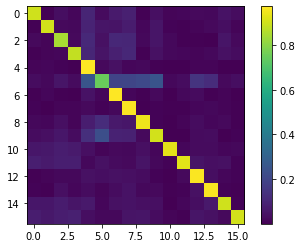

In [ ]:
# Check the correlation (estimates x ground truth)
plt.imshow(corr[maps_permut_index,:])
plt.colorbar()
print(np.diag(corr[maps_permut_index,:]))

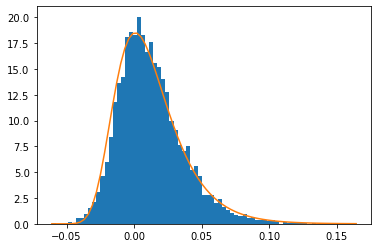

In [ ]:
# Compare the estimated component histogram with the ground truth (#1 component as an example.) 
test_z_scaled = test_z_scaled[:,maps_permut_index] # Permutation correction on estimates
Ind_source_tocompare = 0
loc = loadmat(args.param1fp)[args.param1vn].astype(np.float64)
scale = loadmat(args.param2fp)[args.param2vn].astype(np.float64)
n_out, bins_out, patches_out = plt.hist(test_z_scaled[:,Ind_source_tocompare], density=True, bins='auto')
y = scistats.gumbel_r.pdf(bins_out, loc[Ind_source_tocompare], scale[Ind_source_tocompare])
plt.plot(bins_out,y)